In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as immg
import gc
import numpy as np
import random
from PIL import Image
import warnings
import cv2
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Iaac
#open_image('/content/drive/MyDrive/03_REP_PR_Studio/Semantic Segmentation/images_640/img10.png').data.shape

open_image('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/images_640/img106.png').data.shape

torch.Size([3, 480, 640])

//Path to the dataset

In [ ]:
#IaaC
#path = Path('/content/drive/MyDrive/03_REP_PR_Studio/Semantic Segmentation')  

path = Path('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset') 

In [ ]:
path.ls()

[PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/images'),
 PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/masks'),
 PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/G1_URbanSquares_90_Dataset_label.csv'),
 PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/labelmap.csv'),
 PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/img_mask.csv'),
 PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/labelmap.txt'),
 PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/SS_labelmap.csv'),
 PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/masks_640'),
 PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/images_640')]

In [ ]:
fnames = get_files(path/'images_640/')
fnames_mask = get_files(path/'masks_640/')

In [ ]:
open_image(fnames[2]).data.shape

torch.Size([3, 480, 640])

//Data PreProcessing

In [ ]:
from tqdm.notebook import tqdm,tnrange

In [ ]:
path_im = path/'images_640/'
path_lb = path/'masks_640/'
get_y_fns = lambda x: path_lb/f'{x.stem}.png'       # Function to get masks for a image

In [ ]:
fnames[30],get_y_fns(fnames[30])

(PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/images_640/img303.png'),
 PosixPath('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/SS_RGB_satelitte_Dataset/masks_640/img303.png'))

In [ ]:
def get_classes(fnames):
    class_codes=[]
    for i in tqdm(range(720)):
        class_codes += list(np.unique(np.asarray(Image.open(get_y_fns(fnames[i])))))
    return np.array(list(set(class_codes)))

In [ ]:
# Run this once to get total classes if you want, other wise below cell gives total classes
codes = get_classes(fnames) 

In [ ]:
codes = np.array(codes)
codes

array([  0,   1,   2,   3, ..., 252, 253, 254, 255], dtype=uint8)

In [ ]:
sns.set_style('darkgrid')

//Function to show Drone with Mask

In [ ]:
def drone_mask(f):  # f = file_name
  img_a = immg.imread(f)
  img_a_mask = immg.imread(get_y_fns(f))
  plt.figure(1,figsize=(12,6))
  plt.subplot(121)
  plt.imshow(img_a);plt.title('Raw Drone footage ');plt.axis('off')
  plt.subplot(122)
  plt.imshow(img_a,alpha=0.8);
  plt.imshow(img_a_mask,alpha=0.8);plt.title('Drone with  mask');plt.axis('off')
  plt.show()

//A sample Drone with Mask

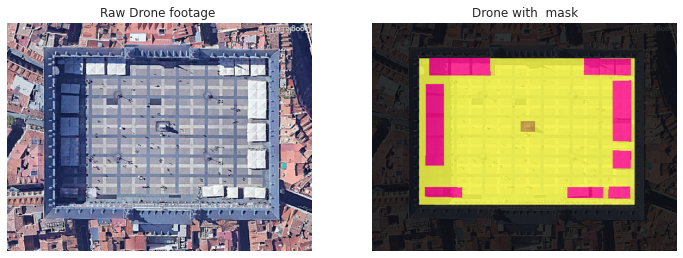

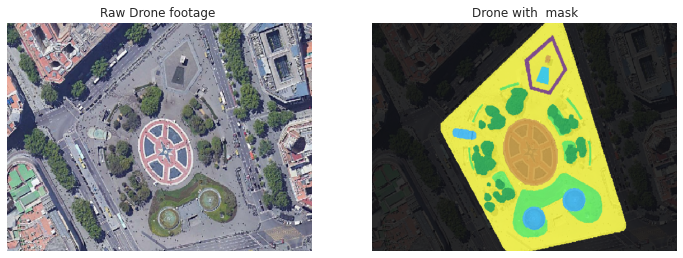

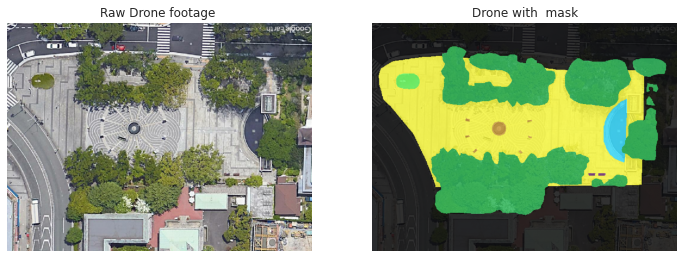

In [ ]:
for i in range(3):
    img_num = random.randint(10,720)
    drone_mask(fnames[img_num])

//Creating A DatabLock for the model

In [ ]:
src=np.array([400,600])
#src=src//2
src

array([400, 600])

In [ ]:
data = (SegmentationItemList.from_folder(path=path_im)  # Location from path
        .split_by_rand_pct(0.2)                          # Split for train and validation set
        .label_from_func(get_y_fns, classes=codes)      # Label from a above defined function
        .transform(get_transforms(), size=src//2, tfm_y=True)   # If you want to apply any image Transform
        .databunch(bs=4)                                   # Batch size  please decrese batch size if cuda out of memory
        .normalize(imagenet_stats))            # Normalise with imagenet stats

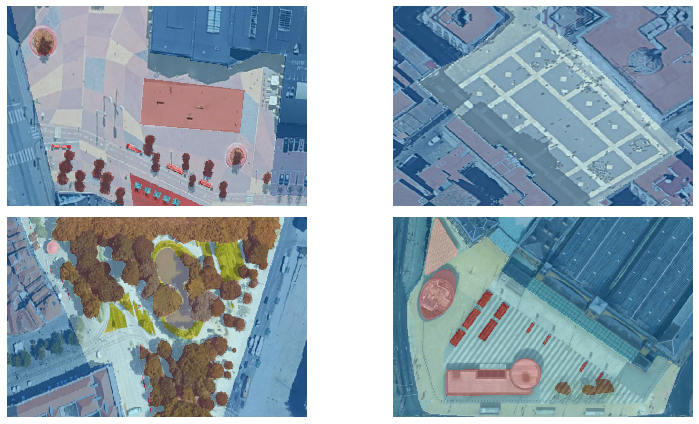

In [ ]:
data.show_batch(rows=2,figsize=(12,6));

In [ ]:
len(data.train_ds), len(data.valid_ds), data.c  

(576, 144, 256)

//Model


In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = -1

def drone_accuracy_mask(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics = drone_accuracy_mask
wd=1e-2    # wd = weight decay

In [ ]:
arch = models.resnet34
learn = unet_learner(data, # DatBunch
                     arch, # Backbone pretrained arch
                     metrics = [metrics], # metrics
                     wd = wd, bottle=True, # weight decay
                     model_dir = '/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/Save/Final/') # model directory to save

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


//Model Summary

 - Finding a suitable learning rate for our model

epoch,train_loss,valid_loss,drone_accuracy_mask,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


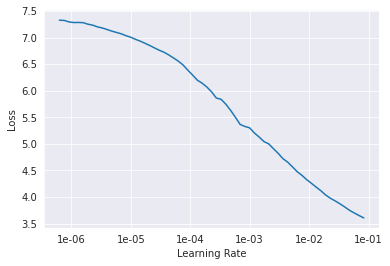

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
gc.collect() # to clear the cache

6644

In [ ]:
callbacks = SaveModelCallback(learn, monitor = 'drone_accuracy_mask', every = 'improvement', mode='max', name = 'best_model' )

In [ ]:
lr = 1e-3           # Learning Rate

In [ ]:
learn.fit(100, lr,callbacks = [callbacks] )

epoch,train_loss,valid_loss,drone_accuracy_mask,time
0,1.251413,0.960352,0.705338,00:42
1,0.950713,0.782501,0.751339,00:25
2,0.860231,0.746770,0.767997,00:25
3,0.752878,0.757928,0.767835,00:25
4,0.715635,0.635608,0.807493,00:24
5,0.659492,0.599435,0.814864,00:25
6,0.654534,0.646703,0.804186,00:25
7,0.598950,0.535090,0.835124,00:24
8,0.559996,0.520882,0.835193,00:25
9,0.560745,0.508012,0.840321,00:25


Better model found at epoch 0 with drone_accuracy_mask value: 0.7053380012512207.
Better model found at epoch 1 with drone_accuracy_mask value: 0.7513389587402344.
Better model found at epoch 2 with drone_accuracy_mask value: 0.7679973840713501.
Better model found at epoch 4 with drone_accuracy_mask value: 0.8074933886528015.
Better model found at epoch 5 with drone_accuracy_mask value: 0.814863920211792.
Better model found at epoch 7 with drone_accuracy_mask value: 0.8351244926452637.
Better model found at epoch 8 with drone_accuracy_mask value: 0.8351929187774658.
Better model found at epoch 9 with drone_accuracy_mask value: 0.84032142162323.
Better model found at epoch 10 with drone_accuracy_mask value: 0.8556612133979797.
Better model found at epoch 13 with drone_accuracy_mask value: 0.866456151008606.
Better model found at epoch 14 with drone_accuracy_mask value: 0.8734089136123657.
Better model found at epoch 15 with drone_accuracy_mask value: 0.875227153301239.
Better model foun

epoch,train_loss,valid_loss,drone_accuracy_mask,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


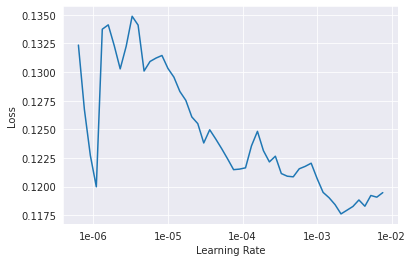

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
gc.collect()

6125

In [ ]:
learn.load('best_model');
callbacks2 = SaveModelCallback(learn, monitor = 'drone_accuracy_mask', every = 'improvement', mode='max', name = 'best_model_ft' )

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(100,max_lr= slice(1e-5,1e-3/2),callbacks = [callbacks2] )

epoch,train_loss,valid_loss,drone_accuracy_mask,time
0,0.114135,0.099588,0.963910,00:26
1,0.108507,0.098402,0.964242,00:26
2,0.104891,0.096704,0.964806,00:26
3,0.104315,0.094405,0.965493,00:26
4,0.102667,0.093482,0.965872,00:26
5,0.097940,0.093003,0.966051,00:26
6,0.099827,0.091576,0.966585,00:26
7,0.101802,0.091177,0.966667,00:27
8,0.098161,0.091011,0.966759,00:26
9,0.094907,0.089400,0.967324,00:26


Better model found at epoch 0 with drone_accuracy_mask value: 0.9639102220535278.
Better model found at epoch 1 with drone_accuracy_mask value: 0.9642421007156372.
Better model found at epoch 2 with drone_accuracy_mask value: 0.9648064374923706.
Better model found at epoch 3 with drone_accuracy_mask value: 0.9654929041862488.
Better model found at epoch 4 with drone_accuracy_mask value: 0.9658719301223755.
Better model found at epoch 5 with drone_accuracy_mask value: 0.9660508036613464.
Better model found at epoch 6 with drone_accuracy_mask value: 0.9665851593017578.
Better model found at epoch 7 with drone_accuracy_mask value: 0.9666669368743896.
Better model found at epoch 8 with drone_accuracy_mask value: 0.9667591452598572.
Better model found at epoch 9 with drone_accuracy_mask value: 0.9673240184783936.
Better model found at epoch 11 with drone_accuracy_mask value: 0.9678320288658142.
Better model found at epoch 17 with drone_accuracy_mask value: 0.9680043458938599.
Better model f

// Results

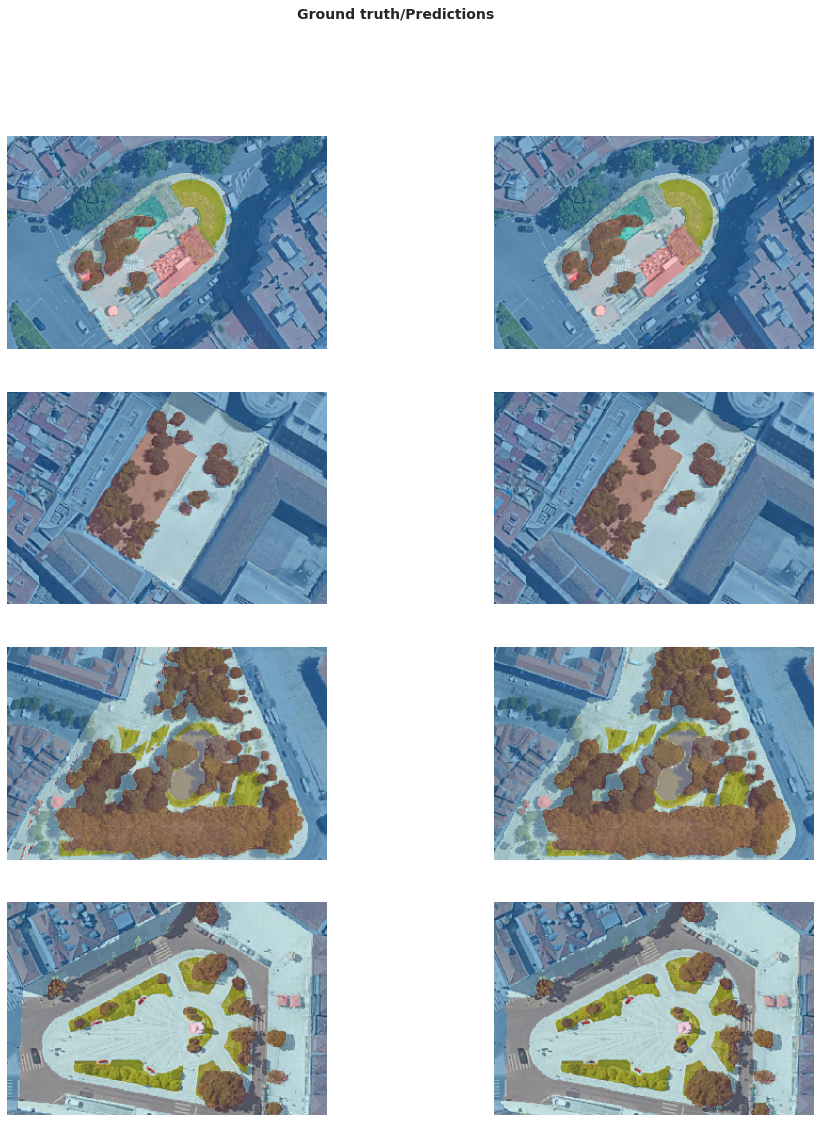

In [ ]:
learn.show_results(rows = 4, figsize=(16,18))

In [ ]:
learn.save('stage-1-big')  # saving the model 

// Export results

In [ ]:
learn.export('/content/drive/MyDrive/IAAC/MaCAD/MOD.03/Studio/Colab/Save/Final/results')

In [ ]:
def drone_predict(f):
    img = open_image(f).resize((3,200,300))
    mask = learn.predict(img)[0]
    _,axs = plt.subplots(1,3, figsize=(24,10))
    img.show(ax=axs[0], title='no mask')
    img.show(ax=axs[1], y=mask, title='masked')
    mask.show(ax=axs[2], title='mask only', alpha=1.)

In [ ]:
for i in range(6):
    n = random.randint(20,90)
    drone_predict(fnames[n])

NameError: ignored